# Data Science with Neo4j Using Yelp Data

Status: Work in Progress

### Course Overview

This 4-part series covers data science concepts and techniques applicable to various domains and industries. Through practical examples, we will show just how easy it is to derive insights given a particular dataset. Thanks to Yelp, we have access to business, review and user data across multiple cities.  Using Neo4j to model and store our highly connected data, we will make sense of it, using a combination of Cypher, graph-specific algorithms and standard Python machine learning libraries.  Below are the topics that we will cover in this course:

1.  Exploratory Data Analysis
2.  Segmentation and Community Detection
3.  Similarity and Recommendations
4.  Influencers and Centrality

### Pre-requisites

This course assumes that you have basic knowledge of the Cypher query language and some scripting in Python. For those not yet familiar with Cypher but have some experience with SQL, you will quickly discover that Cypher is just SQL for graphs! To help you get started with Cypher, or simply brush up, please click [here](https://neo4j.com/docs/cypher-refcard/current/).  

We will use Python to demonstrate traditional, non-graph specific data science techniques and algorithms.  While other languages have equally rich data manipulation and machine learning libraries, we have chosen Python for this course as it has a relatively low learning curve.  It is also a general purpose language as opposed to statistics-focused and has great emphasis on code readability. For Python resources, please click [here](https://www.python.org/doc/).
 
One of the key concepts in the field of data science is the idea of reproducibility.  This means that we want our analysis to be performed so that it is well-documented and can easily be re-executed if needed.  For this, we use Jupyter Notebook which allows us to combine Python code, output, visualization and text all in one place!  To learn more about the notebook, please click [here](http://jupyter.org).

The data required for this course has been pre-loaded into Neo4j. However, if you are interested in getting hands-on experience in creating your own Neo4j database, please follow instructions [here](https://github.com/neo4j-contrib/neo4j-data-science-yelp/blob/master/notebooks/neo4j_yelp_00_data_load.ipynb).

### Module 1: Exploratory Data Analysis

The first thing we need to do when given a dataset is explore it. This allows us to understand the population that we are working with, as well as the quality of the data at hand.  Simple descriptive statistics like counts, averages and percentages help us gain insight into the various dimensions present in the data. In addition, visualizing distributions is useful in discerning values that are considered normal from those deemed to be extreme. In statistics, extreme values are commonly referred to as "outliers".

In the data science pipeline, it is at the exploratory stage that we often discover that data is hardly ever clean or perfect. This means that we will come across dimensions or variables that either have missing, incorrect or extreme values.  Although it is beyond the scope of this course, it is worth noting that as data scientists, we learn to make adjustments to make the data more feasible to work with.  Examples of common techniques include applying transformation functions to variables, imputing missing values and deriving new variables from existing ones.

In this module, we will focus solely on dataset exploration. Data cleansing techniques is not within the scope of this course.

### Understanding the Toronto Food Scene

Our goal is to understand the food scene in one of the most diverse cities in the world: Toronto!  At the time of writing, [Statistics Canada](http://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/page.cfm?Lang=E&Geo1=CSD&Code1=3520005&Geo2=PR&Code2=01&Data=Count&SearchText=toronto&SearchType=Begins&SearchPR=01&B1=All) estimates that Toronto is home to 2.7 million people, nearly half of whom were born outside of Canada (approximately 1.3 million).  Known for being a multi-cultural city, what can we discover about its food culture?  In this module, we will demonstrate how to perform exploratory data analysis using a subset of the Yelp dataset.  While there are other cities and businesses present in the data, we will focus our analysis on restaurants located in Toronto.

Here's the graph data model that we are working with:
(insert property graph model below)

We have Users who <i>wrote</i> Reviews, and these Reviews are <i>review of</i> Businesses.  A Business is <i>in</i> a Category and it is located <i>in</i> a City, which in turn is <i>in</i> a State.  Note also that Users can be <i>friends with</i> other Users.  

In [3]:
from neo4j.v1 import GraphDatabase, basic_auth
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=basic_auth("neo4j", "neo4jneo4j"))

### Part 1: Descriptive Statistics

In this section, we compute high-level metrics associated with our population of interest.  From our property graph data model, this includes the following entities: Business, Review and User. Through Cypher queries, we will discover insights related to Toronto restaurants: the proportion of the city's overall service industry that they account for, their distribution by neighborhood, as well as their quality as inferred by user ratings.

First, let's understand the size of the service industry in Toronto and the proportion that restaurants account for.

#### Query 1: How many businesses are there in Toronto?

In [60]:
%%time

query1 = """
         MATCH (b:Business)-[:IN_CITY]->(c:City {name:'Toronto'})
         RETURN COUNT(b) AS num_businesses
         """

with driver.session() as session:
    result1 = session.run(query1)

for record in result1:
    business_count = record['num_businesses']
    
print('Number of businesses in Toronto: {0}\n'.format(business_count))

Number of businesses in Toronto: 17206

CPU times: user 1.37 ms, sys: 1.54 ms, total: 2.91 ms
Wall time: 20.3 ms


In the Cypher query above, we take note of two things: first, the use of the name property in the City node to select only businesses in Toronto.   Second, the use of the aggregate function COUNT(`<expression>`). Those familiar with SQL know that there exists a function with the same name.  Similar to its SQL counterpart, Cypher returns the number of non-null values for the given expression.  

#### Query 2: What percentage of businesses in Toronto are restaurants?

In [64]:
%%time

query2 = """
         MATCH (b:Business)-[:IN_CITY]->(c:City {name:'Toronto'}),
               (b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'})
         RETURN COUNT(b) AS num_restaurants
         """

with driver.session() as session:
    result2 = session.run(query2)

for record in result2:
    restaurant_count = record['num_restaurants']
    
print('Number of restaurants in Toronto: {0}\n'.format(restaurant_count))

Number of restaurants in Toronto: 7148

CPU times: user 1.89 ms, sys: 2.21 ms, total: 4.09 ms
Wall time: 186 ms


Comparing the above to Query 1, we notice an additional clause `(b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'})`.  This filters the result set such that only businesses belonging to the Restaurant category are returned.  

Taking our restaurant count and dividing it by our business count, we see that 42% of businesses in Toronto are restaurants.  

In [65]:
restaurant_count/business_count * 100

41.543647564802974

That's great to know! Now we would like to see how these restaurants are distributed across Toronto. Recall from our property graph data model that a Business has property `neighborhood`. Write a query that returns the number of neighborhoods in Toronto that have restaurants.  Count only those with non-blank values for `neighborhood`. 

#### Practice Exercise:  How many neighborhoods are there in Toronto that have restaurants? 

In [68]:
%%time
ex1 = """
    
    MATCH (b:Business)-[:IN_CITY]->(c:City {name:'Toronto'}),
          (b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'}) 
    WHERE b.neighborhood <> ''       
    RETURN COUNT(DISTINCT (b.neighborhood)) AS num_neighborhoods     
    
    """

with driver.session() as session:
    result_ex1 = session.run(ex1)

for record in result_ex1:
    neighborhood_count = record['num_neighborhoods']
    
print('Number of neighborhoods in Toronto: {0}\n'.format(neighborhood_count))


Number of neighborhoods in Toronto: 72

CPU times: user 1.99 ms, sys: 1.98 ms, total: 3.97 ms
Wall time: 167 ms


resume here

### 3.  What is the breakdown of restaurants by neighborhood?

converting record to list to dataframe

In [36]:
%%time

query3 = """
    
    MATCH (b:Business)-[:IN_CITY]->(c:City {name:'Toronto'}),
          (b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'}) 
    WHERE b.neighborhood <> ''       
    RETURN b.neighborhood as neighborhood, COUNT(b) as num_restaurants
    ORDER BY num_restaurants DESC
    
    """

with driver.session() as session:
    result3 = session.run(query3)

neighborhood_list = []
for record in result3:
    neighborhood_list.append(dict(record))
    
neighborhood_df = pd.DataFrame(neighborhood_list)

# Compute distribution of restaurants by neighborhood and display the top 10
neighborhood_df['pct_total'] = neighborhood_df['num_restaurants'] / restaurant_count * 100

display(neighborhood_df.head())

,neighborhood,num_restaurants,pct_total
0,Downtown Core,666,9.317292
1,Scarborough,437,6.113598
2,Etobicoke,254,3.553442
3,Entertainment District,227,3.175713
4,Leslieville,168,2.350308


CPU times: user 17 ms, sys: 2.74 ms, total: 19.7 ms
Wall time: 265 ms


We see that 9% of restaurants in Toronto are located in the Downtown Core.

### 4. How many reviews are there in total?

In [37]:
%%time

query4 = """
    
    MATCH (b:Business)-[:IN_CITY]->(c:City {name:'Toronto'}),
          (b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'})
    RETURN SUM(b.num_reviews) as num_reviews
    
    """

with driver.session() as session:
    result4 = session.run(query4)

for record in result4:
    review_count = record['num_reviews']
    
print('Number of reviews: {0}\n'.format(review_count))

Number of reviews: 303757

CPU times: user 1.77 ms, sys: 2.35 ms, total: 4.12 ms
Wall time: 283 ms


### Practice Exercise: What is the average number of reviews per restaurant?

cypher avg

In [38]:
%%time

ex2 = """
    
    MATCH (b:Business)-[:IN_CITY]->(c:City {name:'Toronto'}),
          (b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'})
    RETURN AVG(b.num_reviews) as avg_num_reviews                        // introducing AVG here
    
    """

with driver.session() as session:
    result_ex2 = session.run(ex2)

for record in result_ex2:
    review_avg = record['avg_num_reviews']
    
print('Average number of reviews per restaurant: {0}\n'.format(review_avg))

Average number of reviews per restaurant: 42.4953833240067

CPU times: user 2.17 ms, sys: 2.28 ms, total: 4.45 ms
Wall time: 469 ms


We see that on average, a restaurant in Toronto has 42 reviews.

### 5. What does the distribution of average ratings look like?

Each restaurant has an average rating associated with it.  The values range from 1 to 5, with 5 being the highest.   The answer to this question should give us insight into the quality of restaurants in Toronto as expressed by Yelp users.

In [40]:
%%time

query5 = """
    
    MATCH (b:Business)-[:IN_CITY]->(c:City {name:'Toronto'}),
          (b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'})
    RETURN b.id as id, b.name as name, b.avg_rating as avg_rating
    
    """

with driver.session() as session:
    result5 = session.run(query5)

rating_list = []
for record in result5:
    rating_list.append(dict(record))
    
rating_df = pd.DataFrame(rating_list)
display(rating_df[['id','name','avg_rating']].head())

,id,name,avg_rating
0,Q3BUdZTMw8KRd-3QYtTyAg,Jetsun's Juicy Burger,2.5
1,GWngEFlr9ixVKetxenafOw,The Thai Grill,2.5
2,vBGfITg_FEkFYMQwNagbBA,Burrito Caliente Latin Grill,4.5
3,35ET2yviSxhkMmQa89rFKA,The Jersey Giant,3.0
4,kL7u1A1lIsefy_NGYZN9vg,La Prep,4.0


CPU times: user 497 ms, sys: 6.24 ms, total: 503 ms
Wall time: 540 ms


Let's look at some descriptive statistics related to average rating.

In [41]:
rating_df.describe([.25, .5, .75, 0.90])

,avg_rating
count,7148.000000
mean,3.423475
std,0.741883
min,1.000000
25%,3.000000
50%,3.500000
75%,4.000000
90%,4.500000
max,5.000000


We can see that restaurants in Toronto have an average rating of 3.4 stars and a median rating of 3.5 stars.  The median indicates that half of the restaurants have an average rating below 3.5, and the other half have an average rating above 3.5.  Moreover, the 90th percentile indicates that only 10% of restaurants have an average rating of at least 4.5 stars.

Another way to understand the distribution of average ratings is by visualizing it using a histogram.

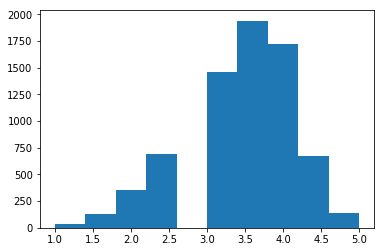

In [42]:
plt.hist(rating_df['avg_rating'])
plt.show()                                     # to do: highlight median & mean in histogram

### 6.  How many users have written reviews for Toronto restaurants?

In [43]:
%%time

query6 = """
    
    MATCH (u:User)-[:WROTE]->(r:Review)-[:REVIEW_OF]->(b:Business)-[:IN_CITY]->(c:City {name:'Toronto'}),
          (b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'})
    RETURN COUNT(DISTINCT(u)) AS num_reviewers
    
    """

with driver.session() as session:
    result6 = session.run(query6)

for record in result6:
    reviewer_count = record['num_reviewers']
    
print('Number of reviewers: {0}\n'.format(reviewer_count))

Number of reviewers: 73041

CPU times: user 2.34 ms, sys: 2.46 ms, total: 4.79 ms
Wall time: 9.02 s


### 7. What is the distribution of average number of reviews per user?  

In [110]:
%%time

query7 = """
    
    MATCH (u:User)-[:WROTE]->(r:Review)-[:REVIEW_OF]->(b:Business)-[:IN_CITY]->(c:City {name:'Toronto'}),
          (b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'})
    RETURN DISTINCT u.id, u.name, u.num_reviews
    
    """

# Store user review data in a list
user_review_list = []
for row in g.run(query7):
    user_review_list.append(row)
    
# Convert user_review_list to a dataframe and re-label columns
user_review_df         = pd.DataFrame(user_review_list)
user_review_df.columns = [['id','name','num_reviews']]
display(user_review_df.shape)
display(user_review_df.head())

(73041, 3)

,id,name,num_reviews
0,3uGBiaa_4BmrA5Nyj6hFRA,Ian,23
1,SML6__mXgEbA4DZkVchruA,Dyna,102
2,b4Dvi7D0LkrJcyzEsP0w4A,Brian,100
3,DxhQiEgLB_PNi69Lt6nHKQ,Mel,351
4,mrru6hbeQLvagU4vkfuqmw,Jenny,331


CPU times: user 6.64 s, sys: 37.6 ms, total: 6.67 s
Wall time: 6.74 s


In [44]:
%%time

query7 = """
    
    MATCH (u:User)-[:WROTE]->(r:Review)-[:REVIEW_OF]->(b:Business)-[:IN_CITY]->(c:City {name:'Toronto'}),
          (b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'})
    RETURN DISTINCT u.id as id, u.name as name, u.num_reviews as num_reviews
    
    """

with driver.session() as session:
    result7 = session.run(query7)

user_review_list = []
for record in result7:
    user_review_list.append(dict(record))
    
user_review_df = pd.DataFrame(user_review_list)
display(user_review_df[['id','name','num_reviews']].head())

,id,name,num_reviews
0,3uGBiaa_4BmrA5Nyj6hFRA,Ian,23
1,SML6__mXgEbA4DZkVchruA,Dyna,102
2,b4Dvi7D0LkrJcyzEsP0w4A,Brian,100
3,DxhQiEgLB_PNi69Lt6nHKQ,Mel,351
4,mrru6hbeQLvagU4vkfuqmw,Jenny,331


CPU times: user 4.52 s, sys: 109 ms, total: 4.63 s
Wall time: 13.9 s


In [45]:
user_review_df.describe([.25, .5, .75, 0.90])

,num_reviews
count,73041.000000
mean,33.427856
std,129.839337
min,0.000000
25%,2.000000
50%,6.000000
75%,18.000000
90%,63.000000
max,7764.000000


On average, users write 33 reviews.   
To do: Look at how long users have been using Yelp and normalize review count accordingly.

### Part 2: Top Restaurants in Toronto

### 8. What are the top 10 restaurants in this neighborhood based on average rating?

We have seen that 9% of restaurants in Toronto are located in the Downtown Core.  

In [47]:
%%time

query8 = """
    
    MATCH (b:Business {neighborhood: 'Downtown Core'})-[:IN_CITY]->(c:City {name:'Toronto'}),
          (b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'})
    RETURN b.name as name, b.avg_rating as avg_rating, b.num_reviews as num_reviews
    ORDER BY b.avg_rating DESCENDING, b.num_reviews DESCENDING   // explain why we are sorting by num_reviews as well
    LIMIT 10
    
    """

with driver.session() as session:
    result8 = session.run(query8)

restaurant_rating_list = []
for record in result8:
    restaurant_rating_list.append(dict(record))
    
restaurant_rating_df = pd.DataFrame(restaurant_rating_list)
display(restaurant_rating_df[['name','avg_rating','num_reviews']].head(10))

,name,avg_rating,num_reviews
0,Salus Fresh Foods,5.0,33
1,Better than Yia Yia's,5.0,6
2,Waynak Modern Halal Eatery,5.0,5
3,Trinity Square Cafe,5.0,5
4,Chopsticks+Forks,5.0,3
5,Richmond Station,4.5,515
6,Kaiju,4.5,366
7,Kekou Gelato House,4.5,363
8,The Elm Tree Restaurant,4.5,168
9,Dac Biet Burger,4.5,122


CPU times: user 14.5 ms, sys: 3.06 ms, total: 17.6 ms
Wall time: 114 ms


We see that the top 5 restaurants have a perfect average rating of 5.  However, the number reviews for each restaurant is quite low.  Recall that previously, we calculated the average number of reviews per restaurant as 42.  Let's now refine our query to select only those restaurants with at least 42 reviews.

### Practice Exercise: Get the top 10 restaurants in the Downtown Core based on average rating.  Filter to include only those with at least 42 reviews.

In [48]:
%%time

ex3 = """
    
    MATCH (b:Business {neighborhood: 'Downtown Core'})-[:IN_CITY]->(c:City {name:'Toronto'}),
          (b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'})
    WHERE b.num_reviews >= 42                                          // learner to apply WHERE here
    RETURN b.name as name, b.avg_rating as avg_rating, b.num_reviews as num_reviews
    ORDER BY b.avg_rating DESCENDING, b.num_reviews DESCENDING
    LIMIT 10
    
    """

with driver.session() as session:
    result_ex3 = session.run(ex3)

restaurant_rating_list_filtered = []
for record in result_ex3:
    restaurant_rating_list_filtered.append(dict(record))
    
restaurant_rating_df_filtered = pd.DataFrame(restaurant_rating_list_filtered)
display(restaurant_rating_df_filtered[['name','avg_rating','num_reviews']].head(10))

,name,avg_rating,num_reviews
0,Richmond Station,4.5,515
1,Kaiju,4.5,366
2,Kekou Gelato House,4.5,363
3,The Elm Tree Restaurant,4.5,168
4,Dac Biet Burger,4.5,122
5,Jimmy's Coffee,4.5,113
6,Katsuya,4.5,111
7,KINKA IZAKAYA ORIGINAL,4.0,1184
8,Sansotei Ramen,4.0,701
9,Beerbistro,4.0,546


CPU times: user 13.2 ms, sys: 2.76 ms, total: 16 ms
Wall time: 480 ms


### 9.  Let's define restaurant popularity by the number of reviews it has received.  Get the top 10 most popular restaurants in Toronto, irrespective of neighborhood.

In [49]:
%%time

query9 = """
    
    MATCH (b:Business)-[:IN_CITY]->(c:City {name:'Toronto'}),
          (b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'})
    RETURN b.name as name, b.avg_rating as avg_rating, b.num_reviews as num_reviews
    ORDER BY b.num_reviews DESCENDING
    LIMIT 10
    
    """

with driver.session() as session:
    result9 = session.run(query9)

popular_list = []
for record in result9:
    popular_list.append(dict(record))
    
popular_df = pd.DataFrame(popular_list)
display(popular_df[['name','avg_rating','num_reviews']].head(10))

,name,avg_rating,num_reviews
0,Pai Northern Thai Kitchen,4.5,1494
1,Khao San Road,4.0,1270
2,KINKA IZAKAYA ORIGINAL,4.0,1184
3,Banh Mi Boys,4.0,973
4,Seven Lives Tacos Y Mariscos,4.5,945
5,Uncle Tetsu's Japanese Cheesecake,3.5,848
6,Salad King Restaurant,3.5,808
7,Momofuku Noodle Bar,3.0,759
8,Sansotei Ramen,4.0,701
9,Insomnia Restaurant & Lounge,4.0,690


CPU times: user 17.9 ms, sys: 3.01 ms, total: 20.9 ms
Wall time: 1.19 s


### 10. Let's define franchise popularity by the number of locations it has across Toronto.  Get the top 10 franchise restaurants in Toronto.

In [139]:
%%time

query10 = """
    
    MATCH (b:Business)-[:IN_CITY]->(c:City {name:'Toronto'}),
          (b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'})
    RETURN b.name, COUNT(DISTINCT(b.id)) as num_locations
    ORDER BY num_locations DESCENDING
    LIMIT 10
    
    """

franchise_list = []
for row in g.run(query10):
    franchise_list.append(row)
    
# Convert franchise_list to a dataframe and re-label columns
franchise_df         = pd.DataFrame(franchise_list)
franchise_df.columns = [['name','num_locations']]
display(franchise_df.shape)
display(franchise_df.head(10))

(10, 2)

,name,num_locations
0,McDonald's,46
1,Subway,41
2,Tim Hortons,38
3,Starbucks,34
4,Pizza Pizza,33
5,Swiss Chalet Rotisserie & Grill,32
6,Pizzaiolo,25
7,Freshii,23
8,Popeyes Louisiana Kitchen,23
9,Aroma Espresso Bar,21


CPU times: user 34.3 ms, sys: 21.8 ms, total: 56.1 ms
Wall time: 454 ms


In [50]:
%%time

query10 = """
    
    MATCH (b:Business)-[:IN_CITY]->(c:City {name:'Toronto'}),
          (b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'})
    RETURN b.name as name, COUNT(DISTINCT(b.id)) as num_locations
    ORDER BY num_locations DESCENDING
    LIMIT 10
    
    """

with driver.session() as session:
    result10 = session.run(query10)

franchise_list = []
for record in result10:
    franchise_list.append(dict(record))
    
franchise_df = pd.DataFrame(franchise_list)
display(franchise_df[['name','num_locations']].head(10))

,name,num_locations
0,McDonald's,46
1,Subway,41
2,Tim Hortons,38
3,Starbucks,34
4,Pizza Pizza,33
5,Swiss Chalet Rotisserie & Grill,32
6,Pizzaiolo,25
7,Freshii,23
8,Popeyes Louisiana Kitchen,23
9,Aroma Espresso Bar,21


CPU times: user 15.7 ms, sys: 3.2 ms, total: 18.9 ms
Wall time: 957 ms


### TO DO:   
CHANGE DRIVER IN LOAD CSV NOTEBOOK, CREATE NOTEBOOK FOR NEO4J IMPORT, COMPARE RUN TIMES OF LOAD CSV AND NEO4J IMPORT, INCORPORATE STATSCAN DATA, LOAD CHECK-IN DATA TO GET MOST POPULAR RESTAURANT ON A FRIDAY EVENING, DEVELOP STORY AROUND QUERIES IN THIS MODULE
     
NOTE: RESERVING CATEGORY-RELATED QUERIES FOR THE NEXT MODULE OR SNEAK PEEK TO IT WITH SIMPLE QUIZ QUESTION IN THIS MODULE